<a href="https://colab.research.google.com/github/konstantin224/NLP_NER_models/blob/dev/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%B2%D0%B0%D0%BA%D0%B0%D0%BD%D1%81%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

from joblib import dump
from matplotlib import pyplot as plt
from sklearn import model_selection


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для реализации модели, решающей задачу бинарной классификации,нужен корпус текстов, который будет содержать в себе вакансии и прочие тексты. Данные предоставленны проектом *Project Bazaar* и собраны из чатов на платформе *Telegram*, в которых люди публикуют карьерные предложения и общаются на тему поиска работы. Определяем, что одно сообщение из чата соответсвует одному тексту.

Необходимо подготовить данные, первый этап: **извлечение репрезентативной выборки из генеральной совокупности**.

Извлечение выборки, полностью описывающей весь корпус текстов обусловлено тем, что второй этап подготовки данных -- это разметка, то есть присвоение каждому тексту из выборки метки: vacancy или other. Разметка данных производится человеком вручную, этот процесс автоматизировать сложно, поэтому нужно выбрать минимальный массив данных, который будет репрезентивно представлять генеральную совокупность. Извлекать будем десять выборок размером $k = 401$. Каждый элемент будем извлекать с вероятностью $\frac{1}{N-n}$, где N -- размер генеральной совокупности, n -- количество извлечённых элементов, таким образом, сформируем выборку $$Z = \left\{z^k_1,..., z^k_j\right\},$$ где $z^k_j = \left\{x_1,...,x_i\right\}$ -- j-я выборка размером $k = 401$, также здесь $x_i \in X^N$
$i = \overline{1,k}, j = \overline{1,10}$. По итогу получаем выборку $Z$ размерностью $4010$.

Следующий этап -- **разметка данных**. Критерии разметки следующие: если в тесте присутствуют обозначения обязанностей, требований и предложений в отношении соискателя, то это вакансия и тексту присваивается метка vacancy, иначе other.

В данных видно, что разметка проводилась изначально на четыре класса, однако *это обосновано целями проекта* и нет проблем свести данные к двум классам.

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/dataset_all.csv', delimiter='	', encoding='utf-8')

In [4]:
dataset.head()

,Unnamed: 0,message_id,channel_id,message_text,message_type,human_classification
0,0,31976,1421126432,#vacancy #job #sales #NewYork #Philadelphia #...,other,other
1,1,1763,1153633109,ВЕДУЩИЙ СПЕЦИАЛИСТ в BTL-команду Toyota.\n\n К...,other,other
2,2,19619,1181766692,обтравка\n\nНаша фотостудия занимается фотосъё...,vacancy,vacancy
3,3,1208,1113366366,Приветствую\n #вакансия #работа #удаленно\n\nА...,vacancy,vacancy
4,4,1550,1109597805,QA Engineer\nСпециалист по тестированию\n\nИще...,vacancy,vacancy


Третий этап -- **проверка сбалансированности данных**. Это нужно для того, чтобы экземпляров первого и второго класса было поровну и веса модели не подстраивались под определённый класс, в будущем давая репрезентативный результат.

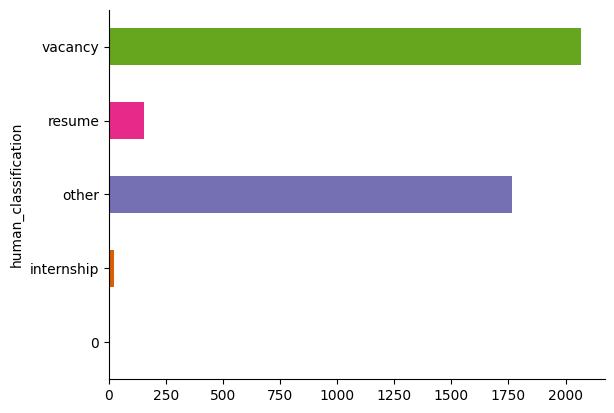

In [6]:
# @title human_classification
dataset.groupby('human_classification').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Поскольку классификация бинарная, то классы internship и resume не пригодятся, поэтому они объединются



In [ ]:
for i in range(len(dataset)):
  if dataset.human_classification[i]!="vacancy":
    dataset.human_classification[i]="other"

Видим, что классы сбалансированы.

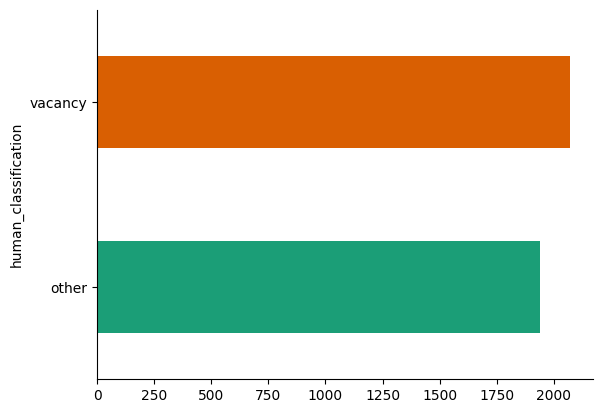

In [9]:
# @title human_classification
dataset.groupby('human_classification').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Четвертый этап в подготовке данных -- это разбиение их на обучающую и тестовую выборку, пусть обучающая будет $70$ процентов от общего массива данных, то есть $2807$ текстов, тестовая $30$, то есть $1203$ текста

In [10]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(dataset.message_text,
                                                                                    dataset.human_classification,
                                                                                    test_size = 0.3)

Поскольку проект не располагает большими вычислительными ресурсами, поэтому целесообразнее всего использовать связку one hot encoding и TF-IDF вместе с методом опороных векторов.


Модель из себя представляет конвейер, который сначала токенизирует предложения и переводит их в векторный формат, потом подсчитывает коэффициенты TF-IDF. По итогу получается матрица размерностью $2807 \times  39491$.

Поскольку для составления модели используется обучающая выборка, количество строк в модели $2807$. Число $39491$ -- количество слов во всём корпусе текстов.



In [11]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data)
X_train_counts.shape

(2807, 39279)

In [12]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2807, 39279)

После получения матрицы, данные идут на вход методу опорных векторов, в нашем случае он работает с определёнными параметрами, разберём их по порядку.


1. loss - функция потерь, используемая при обучении. Выглядит она так: $$L(M_i) = max\left\{0, 1-M_i\right\}$$
2. penalty - регуляризация. В нашем случае используется квадратичная регуляризация.
матрицу контекстно-зависимых предложений.
3. alpha. Коэффициент регуляризации. В постановке задачи он обозначен как $\gamma$.
4. max iter. Максимальное количество перетасовок данных и проходов по ним.

5. random state. Используется для перестановки данных, чтобы с каждой новой компиляцией результат не менялся

In [ ]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge',
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   max_iter=5,
                                                   random_state=42))])


text_clf_svm = text_clf_svm.fit(train_data, train_labels)

predicted_svm = text_clf_svm.predict(test_data)

Метрика в этой задаче будет precision, recall и F1-score.
Определяются они следующим образом: $$ precision = \dfrac{TP}{TP+FP},\  recall = \dfrac{TP}{TP+FN},\ F_1 =  2\cdot \dfrac{precision \cdot reccal}{precision + recall},$$ где TP -- количество раз, когда модель указывает верную метку, FP -- количество раз, когда модель указывает ложноотрицательную метку, FN -- количество раз, когда модель указывает ложноположительную метку.

In [14]:
precision = precision_score(test_labels,
                     predicted_svm,
                     average='binary',
                     pos_label="vacancy")

recall = recall_score(test_labels,
                  predicted_svm,
                  average='binary',
                  pos_label="vacancy")

f_score = f1_score(test_labels,
             predicted_svm,
             average='binary',
             pos_label="vacancy")

In [15]:
print(f"Показатель модели:\nprecision = {round(precision, 2)}\nrecall = {round(recall, 2)}\nF1_score = {round(f_score, 2)}")

Показатель модели:
precision = 0.93
recall = 0.92
F1_score = 0.93




По итогу значения получились следующие: $$precision =0.95,\ recall = 0.9,\ F_1 = 0.92$$ То есть метод опорных векторов правильно выявляет зависимость в 92\% случаев.

Рассмотрим те же метрики на алгоритме, построенного без методов машинного обучения и они равны следующим значениям:
$$precision =0.82,\ recall = 0.85,\ F_1 = 0.84$$
То есть этот алгоритм предсказывает результат с точностью 84\%, разница небольшая, но она есть и может быть существенна от случая к случаю.

Стоит отметить, что точность у модели, построенного с помощью метода опорных векторов, равна 95\%, а у алгоритма, построенного вручную, 82\%, что говорит о том, что у алгоритма ложных пропусков больше, чем у модели, аналогично с полнотой, у алгоритма ложных срабатываний больше, именно засчёт этого F-мера меньше у алгоритма.